<a href="https://colab.research.google.com/github/Spandana0603/Credit-Card-Fraud-Detection-Using-Machine-Learning/blob/main/NLP_ASSIGNMENT_Q1095454.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loaded CSV with encoding: ISO-8859-1
Loaded dataset rows: 5572
Label distribution:
 label_str
ham     4825
spam     747
Name: count, dtype: int64
Train/Test sizes: (4457, 6) (1115, 6)

Classical pipeline (TF-IDF + LR) report:
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Top TF-IDF terms per class (label_num):
0 ['ok', 'go', 'get', 'come', 'call', 'know', 'gt', 'lt', 'like', 'got']
1 ['phone', 'call', 'call phone', 'free', 'txt', 'text', 'claim', 'url', 'mobil', 'stop']

Fallback pipeline (TF-IDF + LinearSVC) report:
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.93      0.95       149

    accuracy                 

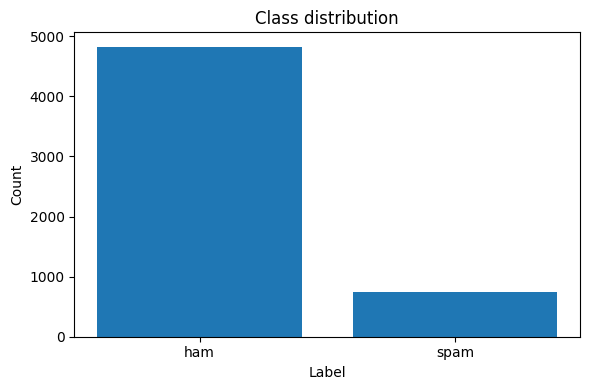

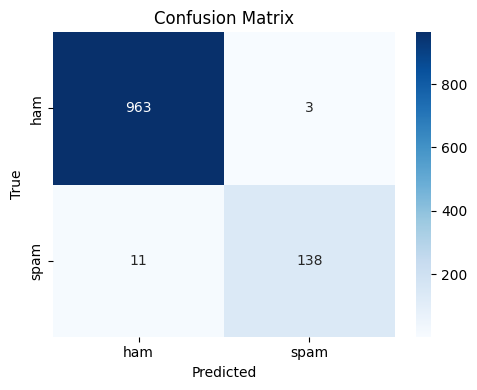

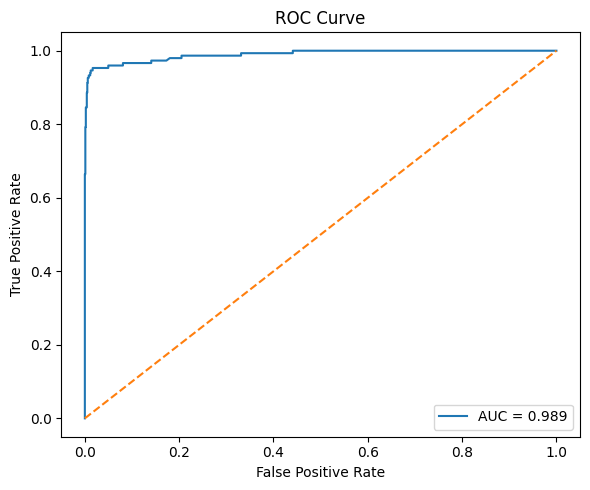

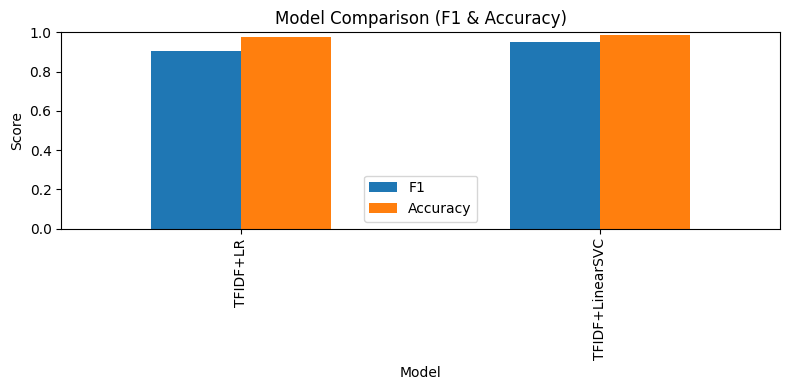


All artifacts saved to: /content/nlp_assignment_outputs


In [ ]:
import os
import re
import sys
import pickle
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)


_try_nltk = True
_try_gensim = True
_try_transformers = True
_try_spacy = True

try:
    import nltk
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
except Exception:
    _try_nltk = False

try:
    import gensim
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
except Exception:
    _try_gensim = False

try:
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        Trainer,
        TrainingArguments,
    )
    import torch
except Exception:
    _try_transformers = False

try:
    import spacy
except Exception:
    _try_spacy = False


def ensure_nltk_resources():
    if not _try_nltk:
        return
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt")
    try:
        nltk.data.find("corpora/stopwords")
    except LookupError:
        nltk.download("stopwords")
    try:
        nltk.data.find("corpora/wordnet")
    except LookupError:
        nltk.download("wordnet")

def load_csv_smart(path):
    """Try multiple encodings to safely read a CSV."""
    encodings = ["utf-8", "ISO-8859-1", "latin1"]
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Loaded CSV with encoding: {enc}")
            return df
        except Exception as e:
            last_err = e
            continue
    raise last_err

def clean_text_basic(text):
    """Basic cleaning: lowercasing, remove urls/emails/phones, keep alphanum & spacing."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # tokens for urls / emails / phones
    text = re.sub(r"http\S+|www\S+|https\S+", " url ", text)
    text = re.sub(r"\S+@\S+", " email ", text)
    text = re.sub(r"\+?\d[\d \-]{6,}\d", " phone ", text)
    # remove non-alphanumeric except spaces
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def classical_preprocess(text, stopwords_set=None, stemmer=None, lemmatizer=None):
    t = clean_text_basic(text)
    try:
        tokens = word_tokenize(t)
    except Exception:
        tokens = t.split()
    if stopwords_set:
        tokens = [tok for tok in tokens if tok not in stopwords_set and len(tok) > 1]
    else:
        tokens = [tok for tok in tokens if len(tok) > 1]
    if stemmer:
        tokens = [stemmer.stem(tok) for tok in tokens]
    elif lemmatizer:
        tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(tokens)

def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def top_tfidf_terms_by_class(tfidf_vec, X_texts, y, vectorizer, top_n=15):
    """Return top TF-IDF terms per class as a dict: {label: [(term,score), ...]}"""
    X_trans = tfidf_vec.transform(X_texts)
    df = pd.DataFrame(X_trans.todense(), columns=vectorizer.get_feature_names_out())
    groups = {}
    for lbl in np.unique(y):
        idx = np.where(y == lbl)[0]
        if len(idx) == 0:
            continue
        mean_scores = df.iloc[idx].mean(axis=0)
        top = mean_scores.sort_values(ascending=False).head(top_n)
        groups[lbl] = list(zip(top.index.tolist(), top.values.tolist()))
    return groups


def run_pipeline(args):
    OUTDIR = Path(args.outdir)
    OUTDIR.mkdir(parents=True, exist_ok=True)

    # NLTK resource prep
    if _try_nltk:
        ensure_nltk_resources()
        sw = set(stopwords.words("english"))
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
    else:
        sw = set()
        stemmer = None
        lemmatizer = None

    # spaCy POS tagger
    spacy_nlp = None
    if _try_spacy:
        try:
            spacy_nlp = spacy.load("en_core_web_sm")
        except Exception:
            try:
                spacy_nlp = spacy.load("en_core_web_md")
            except Exception:
                spacy_nlp = None

    # Load dataset
    df = load_csv_smart(args.data)
    # Normalize columns: common spam datasets use v1/v2 or label/text
    if "v1" in df.columns and "v2" in df.columns:
        df = df.rename(columns={"v1": "label", "v2": "text"})
    elif "label" not in df.columns or "text" not in df.columns:
        # heuristics
        possible_text_cols = [c for c in df.columns if df[c].astype(str).str.len().mean() > 10]
        if possible_text_cols:
            text_col = possible_text_cols[0]
            label_col = [c for c in df.columns if c != text_col][0] if len(df.columns) > 1 else None
            if label_col is None:
                raise ValueError("Could not find label column. Provide 'label' and 'text' columns.")
            df = df.rename(columns={label_col: "label", text_col: "text"})
        else:
            raise ValueError("Could not identify text column automatically.")

    df = df[["label", "text"]].dropna().reset_index(drop=True)
    # Standardize labels (ham->0, spam->1)
    df["label_str"] = df["label"].astype(str).str.lower().str.strip()
    df["label_num"] = df["label_str"].map(lambda x: 1 if "spam" in x else 0)
    print("Loaded dataset rows:", len(df))
    print("Label distribution:\n", df["label_str"].value_counts())

    # Add cleaned columns
    df["text_clean_basic"] = df["text"].apply(clean_text_basic)
    df["text_classical"] = df["text"].apply(lambda t: classical_preprocess(t, stopwords_set=sw, stemmer=stemmer, lemmatizer=lemmatizer))

    # Train/test split stratified
    train_df, test_df = train_test_split(df, test_size=args.test_size, random_state=args.random_state, stratify=df["label_num"])
    print("Train/Test sizes:", train_df.shape, test_df.shape)


    # Classical pipeline (TF-IDF + LogisticRegression)

    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)
    clf_lr = LogisticRegression(max_iter=1000, solver="liblinear")
    pipeline_classical = Pipeline([("tfidf", tfidf), ("clf", clf_lr)])
    pipeline_classical.fit(train_df["text_classical"], train_df["label_num"])
    preds_classical = pipeline_classical.predict(test_df["text_classical"])

    # Probabilities if available
    proba_classical = None
    try:
        proba_classical = pipeline_classical.predict_proba(test_df["text_classical"])[:, 1]
    except Exception:
        proba_classical = None

    report_classical = classification_report(test_df["label_num"], preds_classical, target_names=["ham", "spam"])
    print("\nClassical pipeline (TF-IDF + LR) report:\n", report_classical)
    save_pickle(pipeline_classical, OUTDIR / "pipeline_classical.pkl")

    # Top TF-IDF terms per class (information extraction proxy)
    top_terms = top_tfidf_terms_by_class(pipeline_classical.named_steps["tfidf"], train_df["text_classical"].tolist(), train_df["label_num"].values, pipeline_classical.named_steps["tfidf"], top_n=12)
    print("\nTop TF-IDF terms per class (label_num):")
    for k, v in top_terms.items():
        print(k, [t for t,s in v[:10]])

    # Fallback pipeline (TF-IDF + LinearSVC) - often higher recall on spam

    pipeline_fallback = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,3), min_df=2, max_df=0.9)),
        ("svc", LinearSVC(max_iter=5000))
    ])
    pipeline_fallback.fit(train_df["text_clean_basic"], train_df["label_num"])
    preds_fallback = pipeline_fallback.predict(test_df["text_clean_basic"])
    report_fallback = classification_report(test_df["label_num"], preds_fallback, target_names=["ham", "spam"])
    print("\nFallback pipeline (TF-IDF + LinearSVC) report:\n", report_fallback)
    save_pickle(pipeline_fallback, OUTDIR / "pipeline_fallback.pkl")


    # Transformer pipeline - DistilBERT example

    transformer_trained = False
    transformer_info = {"attempted": False}
    tf_preds = None
    tf_probs = None

    if args.try_transformer and _try_transformers:
        transformer_info["attempted"] = True
        try:
            model_name = args.transformer_model
            print(f"\nAttempting transformer pipeline using {model_name} ...")
            tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

            # Prepare a small torch Dataset wrapper
            class SimpleDataset(torch.utils.data.Dataset):
                def __init__(self, texts, labels, tokenizer, max_len=128):
                    self.texts = texts
                    self.labels = labels
                    self.tokenizer = tokenizer
                    self.max_len = max_len
                def __len__(self):
                    return len(self.texts)
                def __getitem__(self, idx):
                    enc = self.tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=self.max_len, return_tensors="pt")
                    item = {k: enc[k].squeeze(0) for k in enc}
                    item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
                    return item

            train_texts = train_df["text_clean_basic"].tolist()
            train_labels = train_df["label_num"].tolist()
            test_texts = test_df["text_clean_basic"].tolist()
            test_labels = test_df["label_num"].tolist()

            train_dataset = SimpleDataset(train_texts, train_labels, tokenizer, max_len=128)
            eval_dataset = SimpleDataset(test_texts, test_labels, tokenizer, max_len=128)

            training_args = TrainingArguments(
                output_dir=str(OUTDIR / "transformer_trainer"),
                num_train_epochs=1,
                per_device_train_batch_size=min(32, max(1, args.batch_size)),
                per_device_eval_batch_size=min(64, max(1, args.batch_size)),
                learning_rate=2e-5,
                weight_decay=0.01,
                logging_strategy="no",
                evaluation_strategy="epoch",
                save_strategy="no",
                seed=args.random_state,
            )

            trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
            trainer.train()
            preds = trainer.predict(eval_dataset)
            logits = preds.predictions
            tf_preds = np.argmax(logits, axis=1)
            import scipy.special as sc
            tf_probs = sc.softmax(logits, axis=1)[:, 1]

            report_transformer = classification_report(test_df["label_num"], tf_preds, target_names=["ham", "spam"])
            print("\nTransformer pipeline report:\n", report_transformer)

            model.save_pretrained(OUTDIR / "transformer_model")
            tokenizer.save_pretrained(OUTDIR / "transformer_tokenizer")
            transformer_trained = True
            transformer_info.update({"model_name": model_name, "status": "trained"})
        except Exception as e:
            transformer_info.update({"status": "failed", "error": str(e)})
            print("\nTransformer attempt failed. Error:", e)
    else:
        if args.try_transformer and not _try_transformers:
            print("\nTransformers library not available; skipping transformer pipeline.")
        else:
            print("\nTransformer pipeline not requested; skipping.")


    # Word2Vec training (Skip-gram & CBOW) for semantic reasoning

    w2v_info = {"status": None}
    if args.train_word2vec and _try_gensim:
        try:
            sentences = [simple_preprocess(s) for s in df["text"].astype(str).tolist()]
            print("\nTraining Word2Vec (Skip-gram)...")
            w2v_sg = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4, sg=1, seed=args.random_state)
            print("Training Word2Vec (CBOW)...")
            w2v_cbow = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4, sg=0, seed=args.random_state)
            w2v_sg.save(str(OUTDIR / "word2vec_sg.model"))
            w2v_cbow.save(str(OUTDIR / "word2vec_cbow.model"))
            # Example similarity
            sim_word = "free"
            sim_sg = []
            sim_cbow = []
            try:
                sim_sg = w2v_sg.wv.most_similar(sim_word, topn=10)
                sim_cbow = w2v_cbow.wv.most_similar(sim_word, topn=10)
            except Exception:
                pass
            w2v_info.update({"status":"trained", "sim_free_sg": sim_sg, "sim_free_cbow": sim_cbow})
            print("\nWord2Vec (sg) similar to 'free':", sim_sg[:8])
        except Exception as e:
            w2v_info.update({"status":"failed", "error": str(e)})
            print("\nWord2Vec training failed:", e)
    else:
        w2v_info.update({"status":"skipped_or_gensim_unavailable"})
        if not args.train_word2vec:
            print("\nWord2Vec training not requested; skipping.")
        else:
            print("\nGensim not available; skipping Word2Vec.")


    if transformer_trained:
        final_preds = tf_preds
        final_probs = tf_probs
        final_model_name = transformer_info.get("model_name", "transformer")
    else:
        final_preds = preds_fallback
        final_probs = proba_classical if proba_classical is not None else None
        final_model_name = "TFIDF+LinearSVC_fallback"

    # Build results frame for analysis
    results_df = test_df[["text", "text_clean_basic", "text_classical", "label", "label_num"]].copy().reset_index(drop=True)
    results_df["pred"] = final_preds
    results_df["pred_label"] = results_df["pred"].map({0: "ham", 1: "spam"})
    results_df["correct"] = results_df["pred"] == results_df["label_num"]

    false_positives = results_df[(results_df["label_num"] == 0) & (results_df["pred"] == 1)]
    false_negatives = results_df[(results_df["label_num"] == 1) & (results_df["pred"] == 0)]

    print(f"\nFinal model used: {final_model_name}")
    print("False positives (ham -> spam):", len(false_positives))
    print("False negatives (spam -> ham):", len(false_negatives))

    false_positives.head(20).to_csv(OUTDIR / "false_positives_samples.csv", index=False)
    false_negatives.head(20).to_csv(OUTDIR / "false_negatives_samples.csv", index=False)
    results_df.to_csv(OUTDIR / "test_results_analysis.csv", index=False)

    # Basic bias check: length correlation
    results_df["length"] = results_df["text"].astype(str).str.len()
    avg_len_correct = results_df[results_df["correct"]]["length"].mean()
    avg_len_incorrect = results_df[~results_df["correct"]]["length"].mean()
    print(f"Average length (correct): {avg_len_correct:.1f}, (incorrect): {avg_len_incorrect:.1f}")

    # Confusion matrix & classification report
    y_true = test_df["label_num"].values
    conf_mat = confusion_matrix(y_true, final_preds)
    final_report = classification_report(y_true, final_preds, target_names=["ham", "spam"])
    print("\nConfusion matrix:\n", conf_mat)
    print("\nFinal classification report:\n", final_report)

    # Save summary text
    summary_lines = [
        f"Dataset shape: {df.shape}",
        "Class distribution:\n" + df["label_str"].value_counts().to_string(),
        "\nClassical pipeline report:\n" + report_classical,
        "\nFallback pipeline report:\n" + report_fallback,
        "\nFinal model used: " + final_model_name,
        "\nFinal classification report:\n" + final_report,
        "\nWord2Vec info:\n" + str(w2v_info),
        "\nTransformer info:\n" + str(transformer_info),
        f"\nFalse positives: {len(false_positives)}, False negatives: {len(false_negatives)}",
        f"\nAvg length correct: {avg_len_correct:.1f}, avg length incorrect: {avg_len_incorrect:.1f}",
    ]
    with open(OUTDIR / "experiment_summary.txt", "w") as f:
        f.write("\n".join(summary_lines))


    # Class distribution bar chart
    plt.figure(figsize=(6,4))
    counts = df["label_str"].value_counts()
    plt.bar(counts.index, counts.values)
    plt.title("Class distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(OUTDIR / "class_distribution.png")
    plt.show()
    plt.close()

    # Confusion matrix heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(OUTDIR / "confusion_matrix.png")
    plt.show()
    plt.close()

    # ROC curve
    if final_probs is not None:
        try:
            fpr, tpr, _ = roc_curve(y_true, final_probs)
            roc_auc = roc_auc_score(y_true, final_probs)
            plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
            plt.plot([0,1], [0,1], linestyle="--")
            plt.title("ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend()
            plt.tight_layout()
            plt.savefig(OUTDIR / "roc_curve.png")
            plt.show()
            plt.close()
        except Exception:
            pass

    # Comparison bar chart (F1/Accuracy)
    f1_classical = f1_score(test_df["label_num"], pipeline_classical.predict(test_df["text_classical"]))
    acc_classical = accuracy_score(test_df["label_num"], pipeline_classical.predict(test_df["text_classical"]))
    f1_fallback = f1_score(test_df["label_num"], preds_fallback)
    acc_fallback = accuracy_score(test_df["label_num"], preds_fallback)
    # transformer metrics placeholders if trained
    if transformer_trained:
        f1_tf = f1_score(test_df["label_num"], tf_preds)
        acc_tf = accuracy_score(test_df["label_num"], tf_preds)
    else:
        f1_tf = None
        acc_tf = None

    models = ["TFIDF+LR", "TFIDF+LinearSVC"]
    f1s = [f1_classical, f1_fallback]
    accs = [acc_classical, acc_fallback]
    if transformer_trained:
        models.append("Transformer")
        f1s.append(f1_tf)
        accs.append(acc_tf)

    perf_df = pd.DataFrame({"Model": models, "F1": f1s, "Accuracy": accs})
    ax = perf_df.plot(x="Model", kind="bar", figsize=(8,4), ylim=(0,1))
    plt.title("Model Comparison (F1 & Accuracy)")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.savefig(OUTDIR / "performance_comparison.png")
    plt.show()
    plt.close()

    print("\nAll artifacts saved to:", OUTDIR.resolve())


class Args:
    data = "spam.csv"
    outdir = "./nlp_assignment_outputs"
    test_size = 0.2
    random_state = 42
    try_transformer = False
    transformer_model = "distilbert-base-uncased"
    batch_size = 16
    train_word2vec = True


if __name__ == "__main__":
    args = Args()
    run_pipeline(args)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Please upload the `spam.csv` file using the file upload button in the left sidebar or by running the following code cell:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv
